# Run LIANA & MOFA

## Setup Env

In [28]:
import os, fnmatch

import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq
import mudata as mu

In [2]:
import liana as li
from liana.method.sp import lr_basis

In [3]:
import decoupler as dc
import seaborn as sns

In [4]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/visium"

## Load Processed Objects

### Load Visium

In [5]:
slides = fnmatch.filter(os.listdir(os.path.join(data_dir, 'mdatas')), '*.h5ad')

In [6]:
mdatas = dict()
for slide in slides:
    sample = slide[:-5].split('_')[0]
    print(sample)
    # adatas[slide] = sc.read_h5ad(os.path.join(data_dir, 'visium', 'deconv', slide]]
    mdatas[sample] = mu.read_h5mu(os.path.join(data_dir, 'mdatas', sample + '.h5ad'))
    

f12hr
f6wks
fsham
f4hr
f2dps


## LR basis

Here we run LIANA's lr_basis on each sample

In [7]:
for sample in mdatas.keys():
    adata = mdatas[sample].mod['rna']
    
    # TODO convert this to np.float32 internally
    sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)
    
    lr_basis(adata,
            function_name="jaccard",
            expr_prop=0.1,
            resource_name="MouseConsensus", 
            pvalue_method=None, 
            use_raw=False, 
            #  positive_only:True,
            proximity_key="spatial_connectivities",
    )
    # extract the local scores
    mdatas[sample].mod['lrs']  = li.fun.obsm_to_adata(adata, 'local_scores')


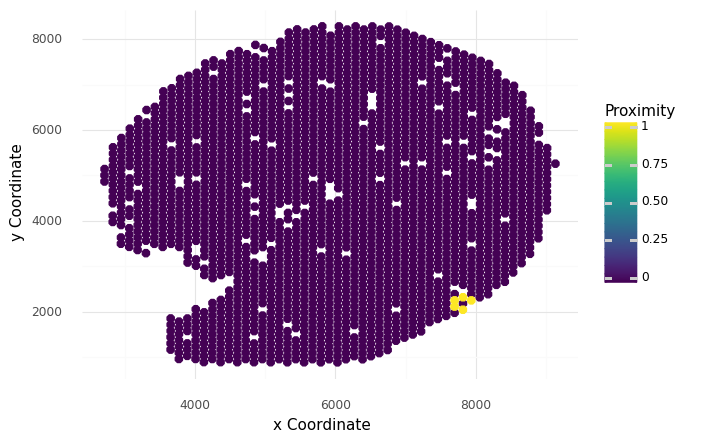

<ggplot: (8733285219749)>

In [8]:
## TODO flip coordinates
li.pl.proximity_plot(adata, idx=1, spatial_key='spatial', proximity_key='spatial_connectivities')

In [9]:
adata.uns['global_res'].sort_values('global_mean').tail(10)

ligand     receptor  ligand_means  ligand_props  receptor_means  \
174     Tgm2        Itgb1      1.062551      0.847393        1.238781   
1113    Spp1  Itgav_Itgb1      5.205983      1.000000        0.987975   
2334   Timp1         Cd63      1.136890      0.811848        2.720397   
197     Tgm2         Sdc4      1.062551      0.847393        1.554439   
507      App        Aplp2      1.451256      0.928436        1.149898   
1157   Mfge8        Itgav      1.465557      0.923697        1.351061   
506    H2-K1        Aplp2      1.565722      0.951659        1.149898   
154   Lgals1        Itgb1      2.485018      0.984360        1.238781   
1154    Calr        Itgav      2.238762      0.986256        1.351061   
530      App         Rpsa      1.451256      0.928436        3.547689   

      receptor_props       interaction  global_mean  global_sd  
174         0.862085        Tgm2&Itgb1     0.780537   0.245009  
1113        0.802844  Spp1&Itgav_Itgb1     0.805632   0.243830  
2334        0.994787        Timp1&Cd63     0.813973   0.246151  
197         0.931280         Tgm2&Sdc4     0.819289   0.205409  
507         0.877725         App&Aplp2     0.856303   0.182598  
1157        0.903791       Mfge8&Itgav     0.861919   0.202380  
506         0.877725       H2-K1&Aplp2     0.864321   0.177198  
154         0.862085      Lgals1&Itgb1     0.864415   0.194182  
1154        0.903791        Calr&Itgav     0.902828   0.170304  
530         0.999526          App&Rpsa     0.929566   0.127791

In [10]:
# save results as modalities
local_lr = li.fun.obsm_to_adata(adata, 'local_scores')
# local_pvals = li.fun.obsm_to_adata(adata, 'local_pvals']

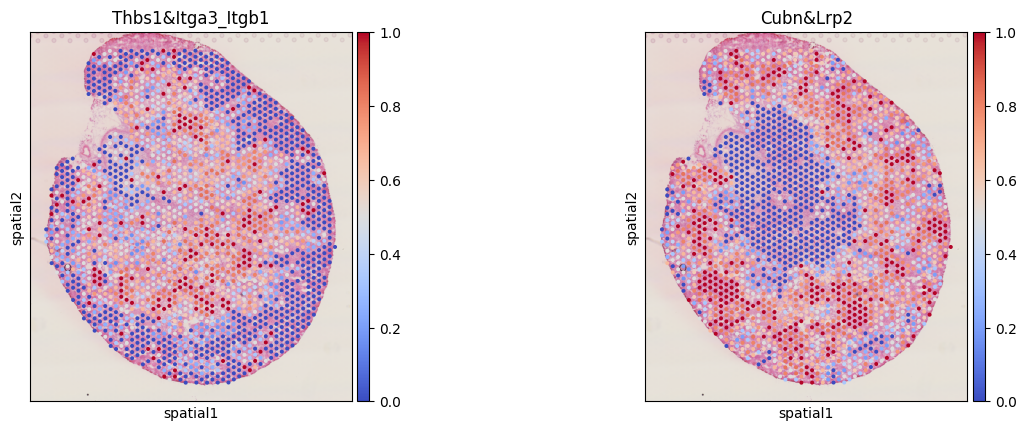

In [11]:
sc.pl.spatial(local_lr, color=['Thbs1&Itga3_Itgb1', 'Cubn&Lrp2'], cmap='coolwarm')

## Run NMF on the whole Dataset

In [12]:
from sklearn.decomposition import NMF

Bind all LR results

In [13]:
lrdatas = dict()
for sample in mdatas.keys():
    lrdatas[sample] = mdatas[sample].mod['lrs']

In [14]:
lrdata_all = sc.concat(lrdatas, join='outer', fill_value=0)

In [15]:
lrdata_all

AnnData object with n_obs × n_vars = 8753 × 941
    obs: 'sample', 'leiden'
    obsm: 'cytosig_estimate', 'dorothea_estimate', 'progeny_estimate', 'spatial', 'tangram_ct_pred', 'local_scores'

In [16]:
# Create an instance of the NMF class
model = NMF(n_components=8, init='random', random_state=0)

# Fit the model to the data and obtain the factorized matrices
W = model.fit_transform(lrdata_all.X)
H = model.components_

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


In [17]:
 ## NOTE take index from adata.obs.index, not from the obsm matrix
columns = [f"Factor{i+1}" for i in range(W.shape[1])]
lrdata_all.obsm['NMF_W'] = pd.DataFrame(W, index=lrdata_all.obs.index, columns=columns)
lrdata_all.varm['NMF_H'] = H.T # NOTE I don't convert to dataframe, because it does not get filtered

## Pathway Enrichment on Ligand-Receptor Factor Loadings

In [18]:
lr_loadings = pd.DataFrame(lrdata_all.varm['NMF_H'], index=lrdata_all.var.index, columns=columns)

In [19]:
lr_loadings

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
interaction                                                                   
Ace&Bdkrb2       0.000000  0.000000  0.034571  0.000000  0.000000  0.000000   
Actr2&Ldlr       0.101534  0.076026  0.086624  0.000000  0.146988  0.038127   
Actr2&Lrp2       0.107018  0.509965  0.253413  0.906904  0.000000  0.224979   
Ada&Dpp4         0.077825  0.005354  0.000000  0.000000  0.000000  0.000000   
Adam10&Axl       0.289762  0.070473  0.258527  0.360077  0.134479  0.362616   
...                   ...       ...       ...       ...       ...       ...   
Wnt7b&Fzd4_Lrp6  0.064564  0.000000  0.000000  0.000000  0.085182  0.016294   
Wnt7b&Tmed5      0.060921  0.000000  0.359361  0.145257  0.133301  0.000000   
Wnt9b&Fzd1_Lrp6  0.000000  0.000000  0.000000  0.000000  0.072747  0.020324   
Wnt9b&Fzd4_Lrp6  0.000000  0.000000  0.000000  0.000000  0.072002  0.021605   
Ybx1&Notch1      0.042007  0.000000  0.262765  0.507727  0.117020  0.225816   

                  Factor7   Factor8  
interaction                          
Ace&Bdkrb2       0.000000  0.093178  
Actr2&Ldlr       0.188892  0.241579  
Actr2&Lrp2       0.058285  0.485606  
Ada&Dpp4         0.000000  0.003646  
Adam10&Axl       0.232699  0.200015  
...                   ...       ...  
Wnt7b&Fzd4_Lrp6  0.302282  0.000000  
Wnt7b&Tmed5      0.268775  0.000000  
Wnt9b&Fzd1_Lrp6  0.000000  0.000000  
Wnt9b&Fzd4_Lrp6  0.000000  0.000000  
Ybx1&Notch1      0.289371  0.066834  

[941 rows x 8 columns]

In [20]:
# load PROGENy pathways
net = dc.get_progeny(organism='Mus musculus', top=5000)

# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('mouseconsensus')

# generate ligand-receptor geneset
lr_progeny = li.fun.generate_lr_geneset(lr_pairs, net, lr_separator="&") # NOTE I should change & to & in basis for consistency
lr_progeny.head()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


source    interaction    weight
1    EGFR    Dll1&Notch1 -1.000584
31   EGFR  Adam10&Notch1 -0.924934
37   MAPK  Adam10&Notch1 -0.925038
58    WNT     Tnf&Notch1 -1.513049
98    WNT  Adam17&Notch1 -0.951469

In [21]:
estimate, pvals = dc.run_mlm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

In [22]:
estimate

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK      NFkB  \
Factor1 -3.056535  1.473505 -0.490332 -0.018404 -0.898498 -1.817910 -0.194591   
Factor2  0.931618  0.077586 -2.670148  0.228835  0.312048  0.413253 -0.684902   
Factor3 -2.425956  3.739267 -1.025604  1.428676 -0.591451  2.130826  0.922835   
Factor4 -0.058074 -0.047278 -1.986731  1.711824 -0.583663  0.872078  0.221046   
Factor5 -1.096349  1.332041 -1.473983  2.236097 -0.516270 -3.578179 -0.388884   
Factor6 -2.844511 -0.324488 -0.630325 -1.286852 -0.290535 -2.324688  0.241054   
Factor7  1.015089  0.479663 -2.608431  0.708973 -0.840830 -0.856872  0.267342   
Factor8  0.285836 -0.680457 -1.255678  4.245229 -0.731063  1.098498 -0.614265   

             PI3K      TGFb      TNFa     Trail      VEGF       WNT       p53  
Factor1 -1.064620  8.953432 -0.844371 -1.986390 -1.161957 -1.166797 -0.012933  
Factor2 -1.340547  1.875622 -0.401418 -0.235234 -0.421811  0.326451  0.538178  
Factor3  0.325257  5.740879  0.333753 -0.681058  1.925592 -0.883071  0.876643  
Factor4 -1.583484  0.335255 -0.523879 -1.087731 -0.606888 -0.629356  1.361123  
Factor5 -3.742241  1.207746 -0.267892 -2.399246 -0.730321  0.168416  1.112475  
Factor6  0.096137  6.231335  0.528005 -0.718937 -1.926967 -1.848248  1.989335  
Factor7 -3.975356  3.160697 -1.507477 -1.608389  0.708795  0.403185  0.560568  
Factor8 -2.043788  0.788094 -0.276686 -0.714105 -0.262184 -2.120354  0.960405

<AxesSubplot:>

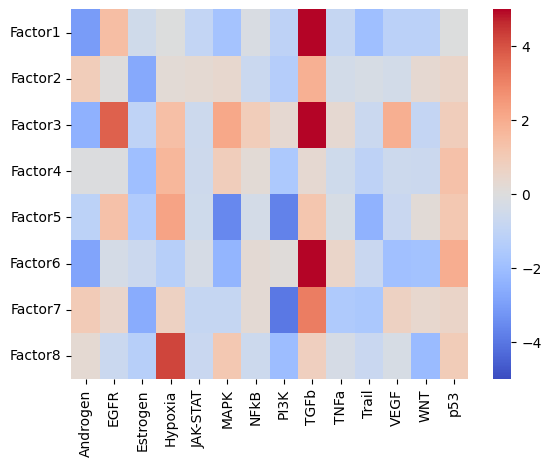

In [23]:
sns.heatmap(estimate, cmap='coolwarm', center=0, vmin=-5, vmax=5)

### Transfer NMF factors to the individual samples

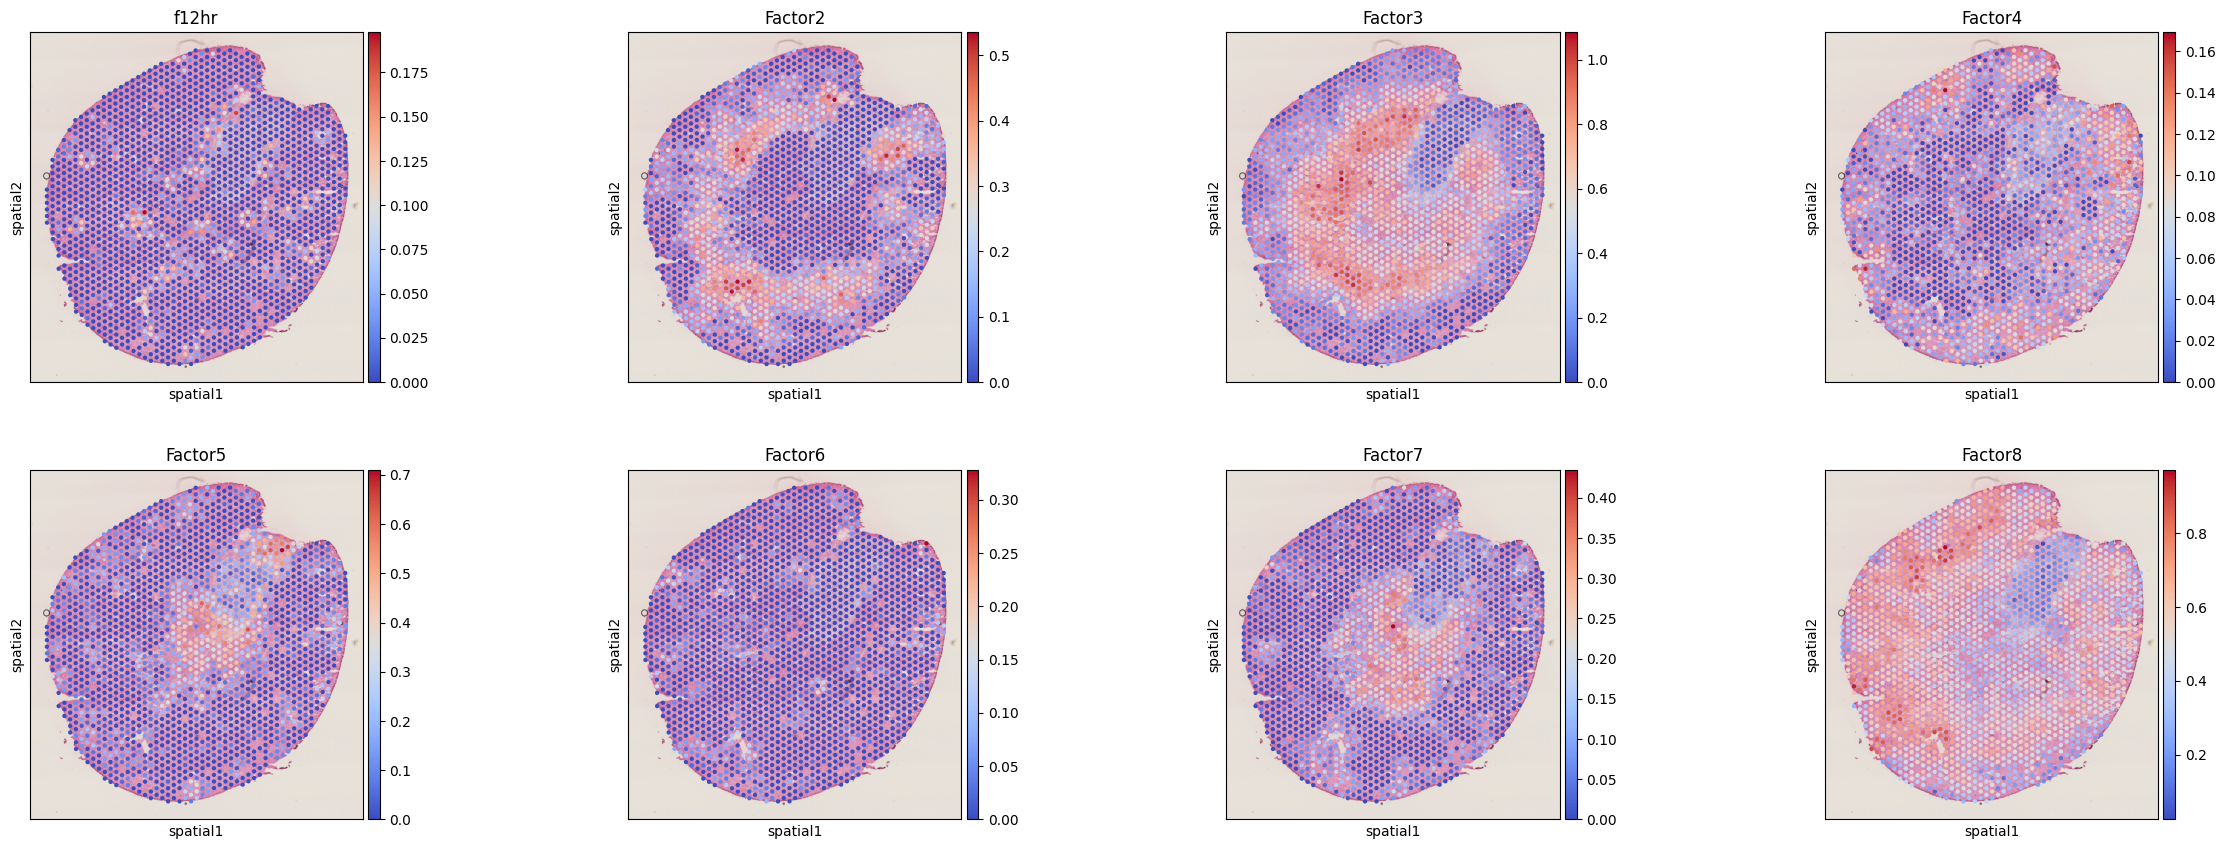

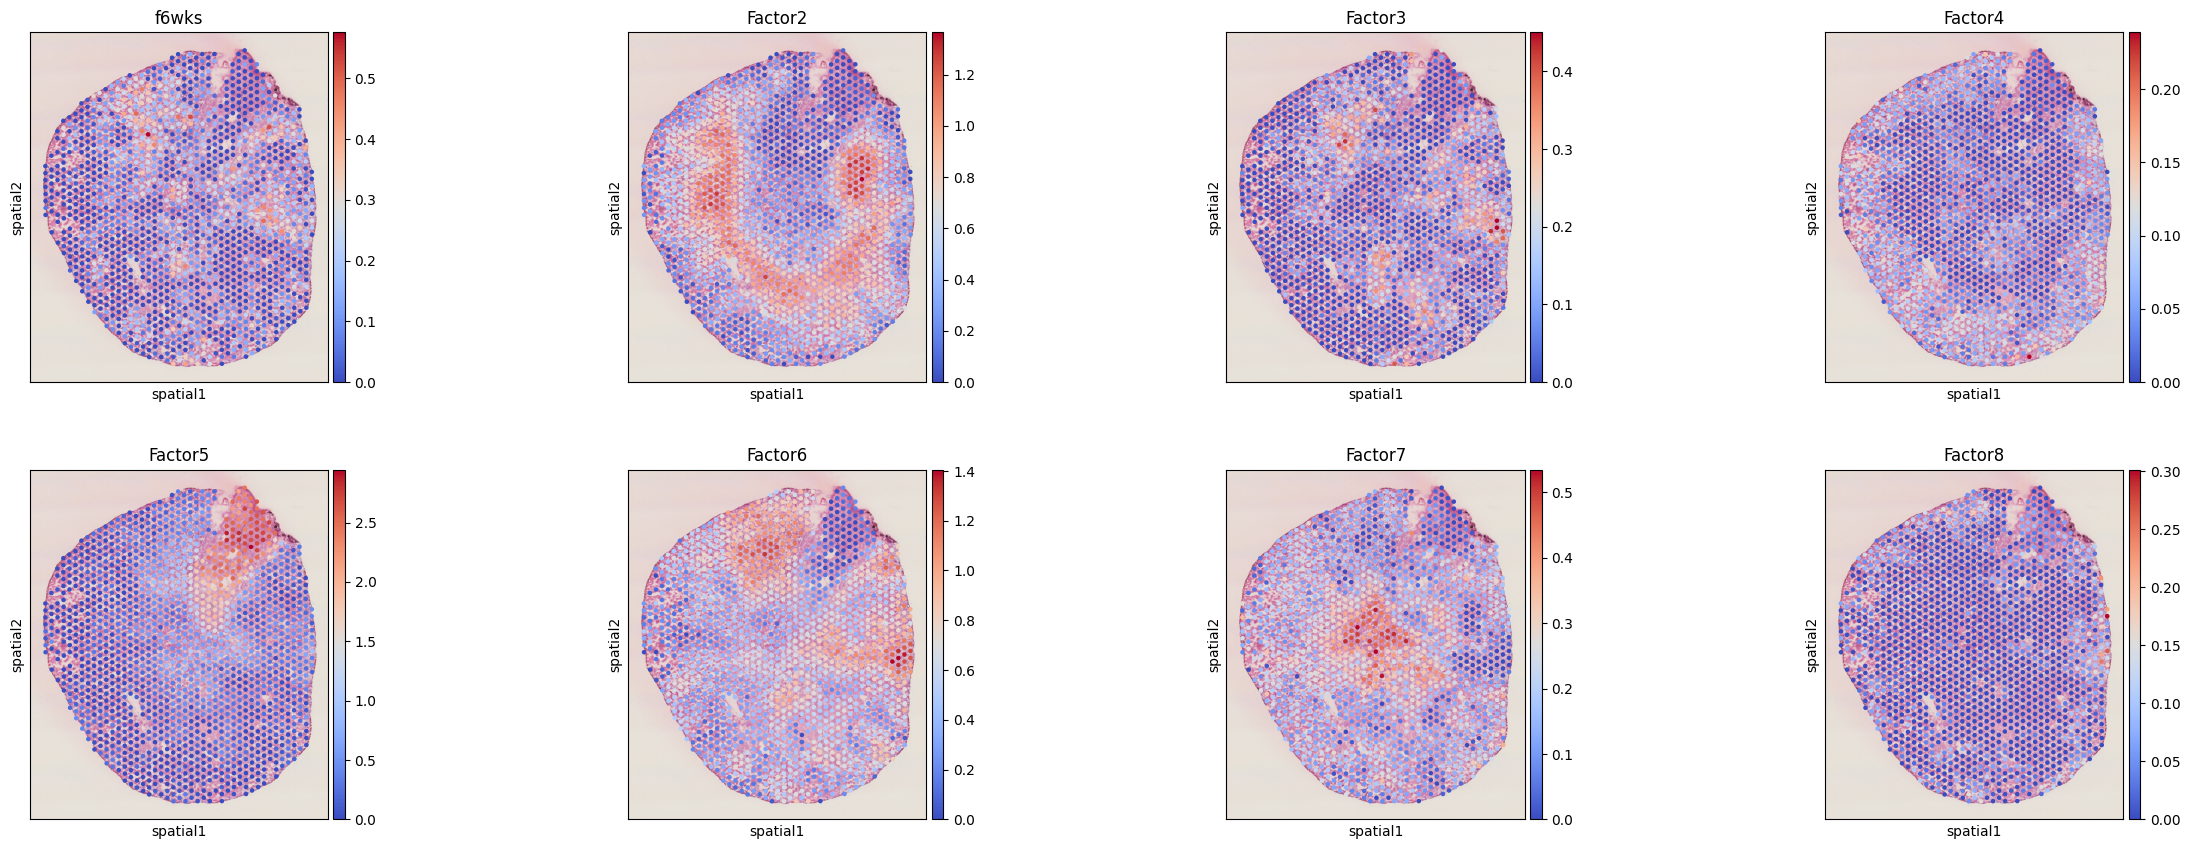

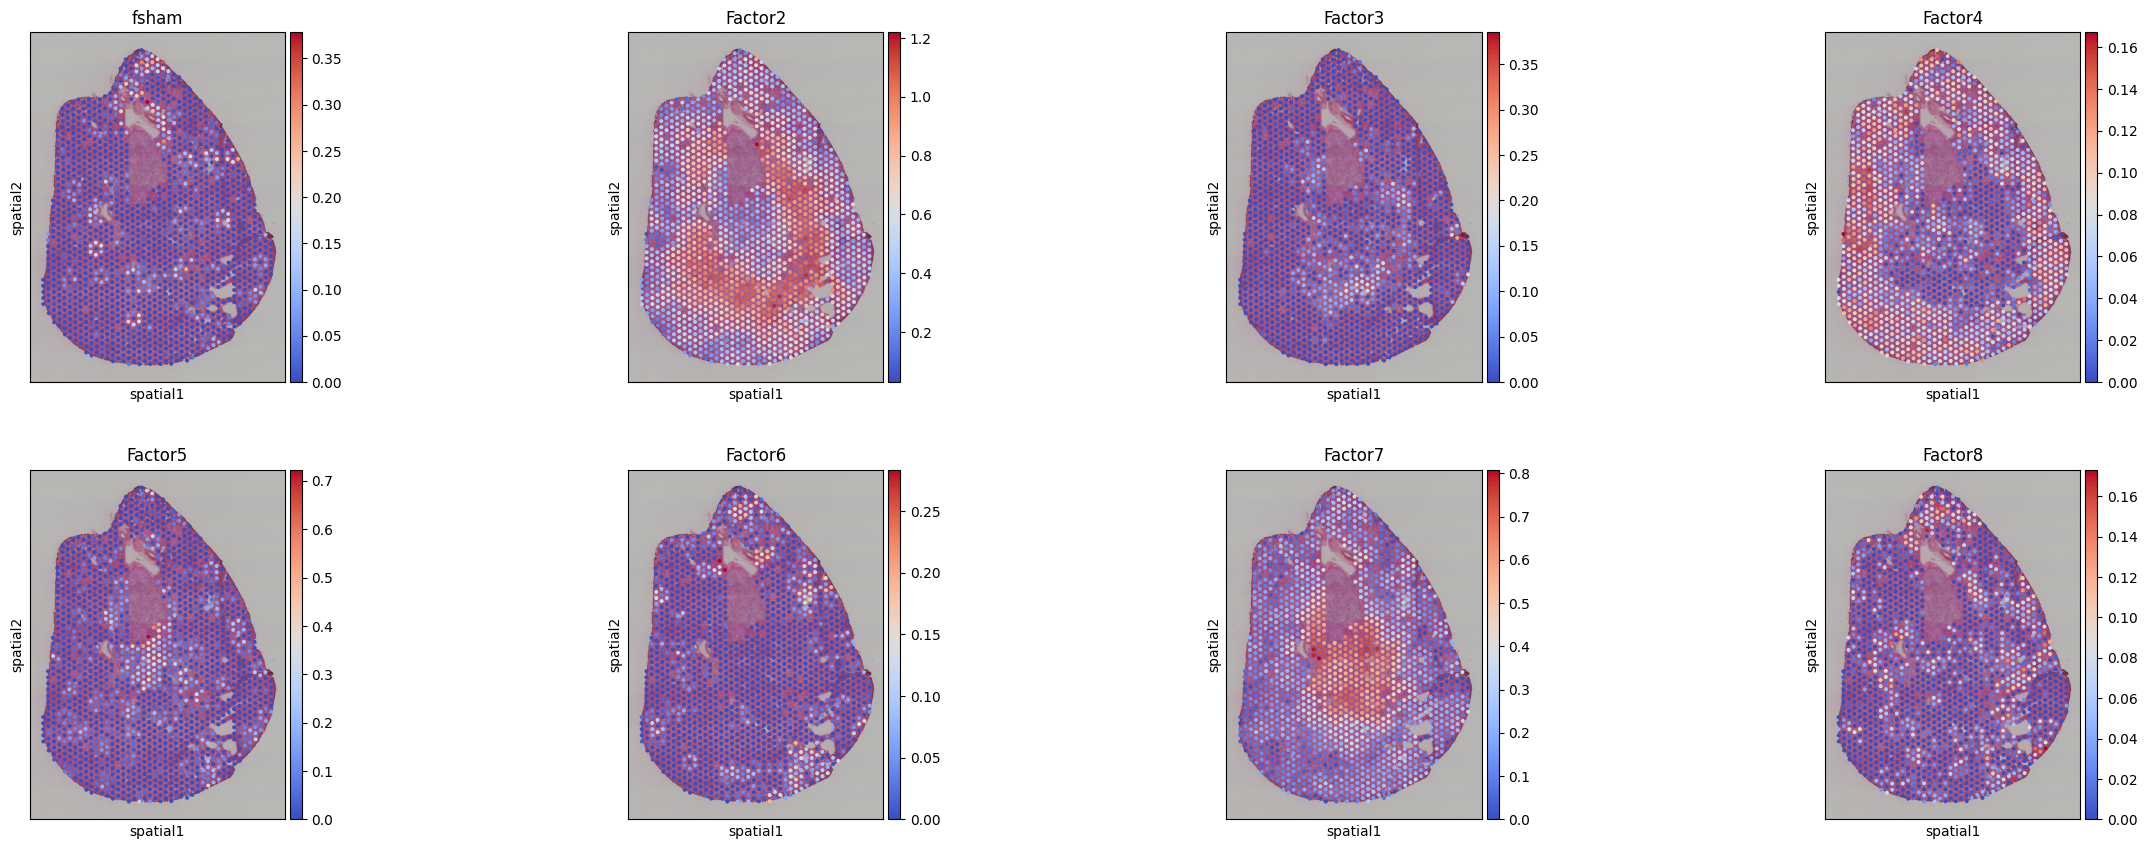

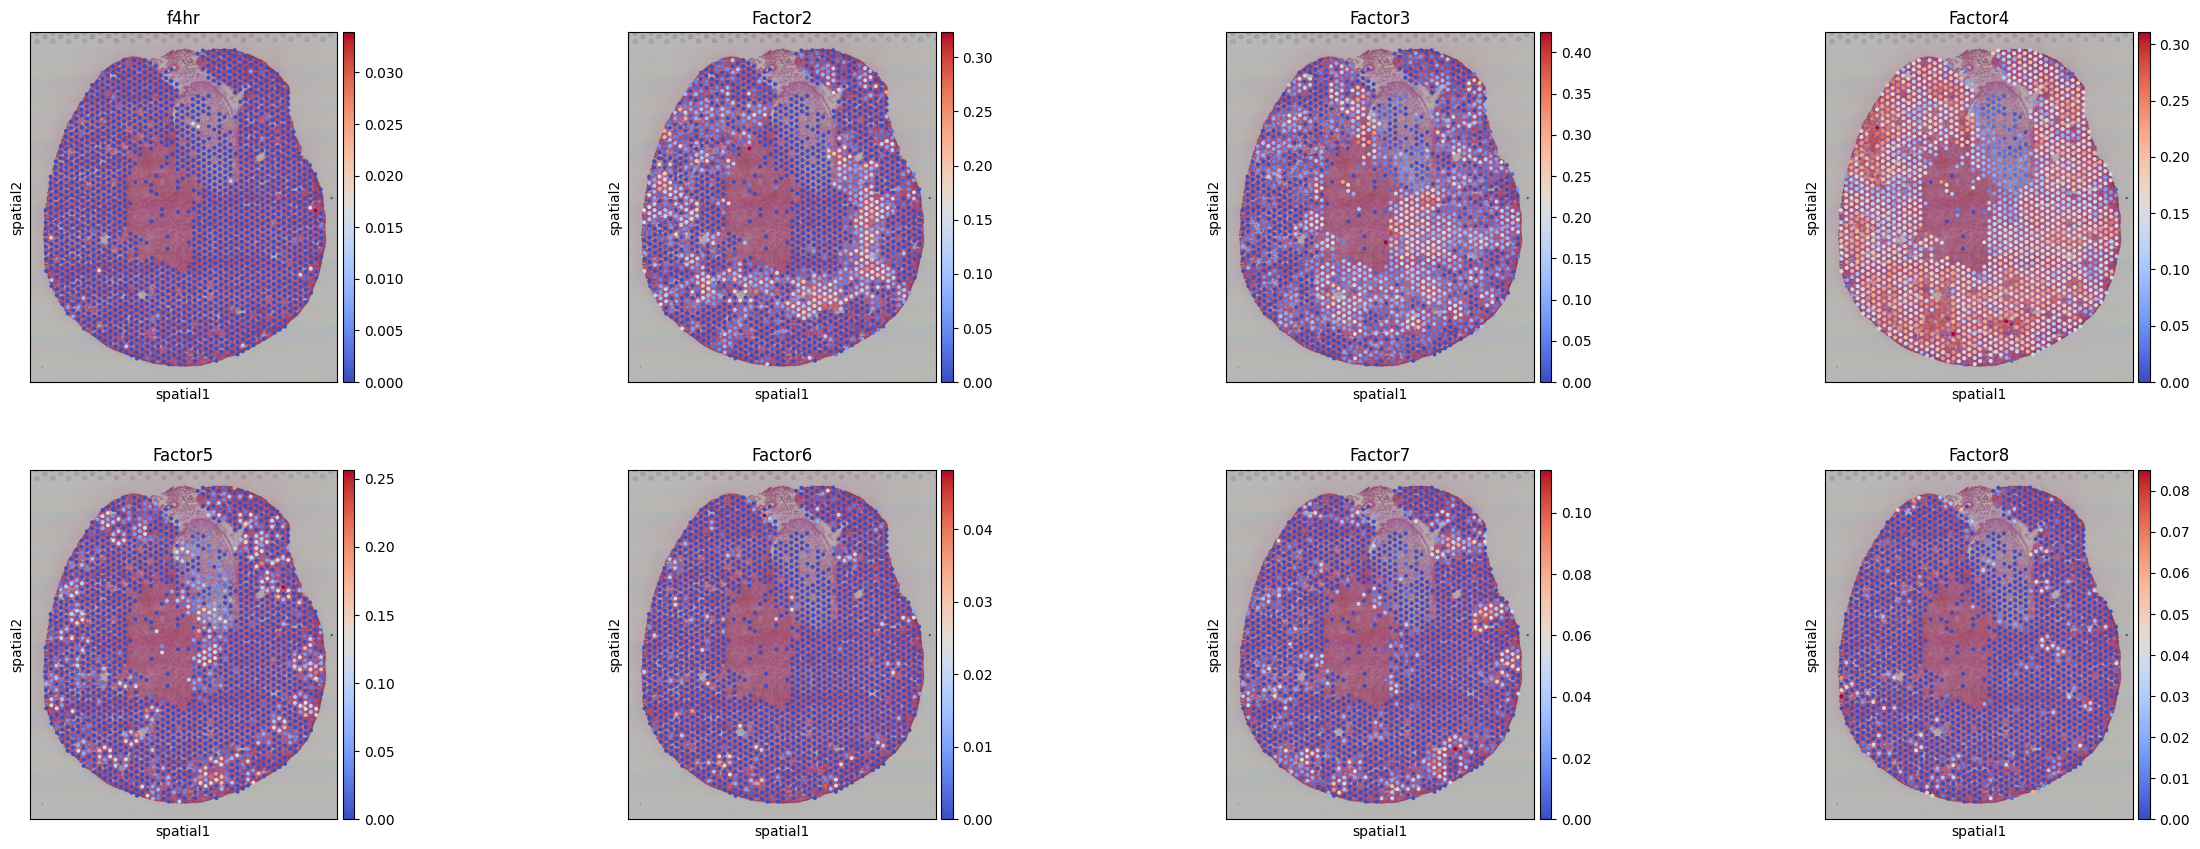

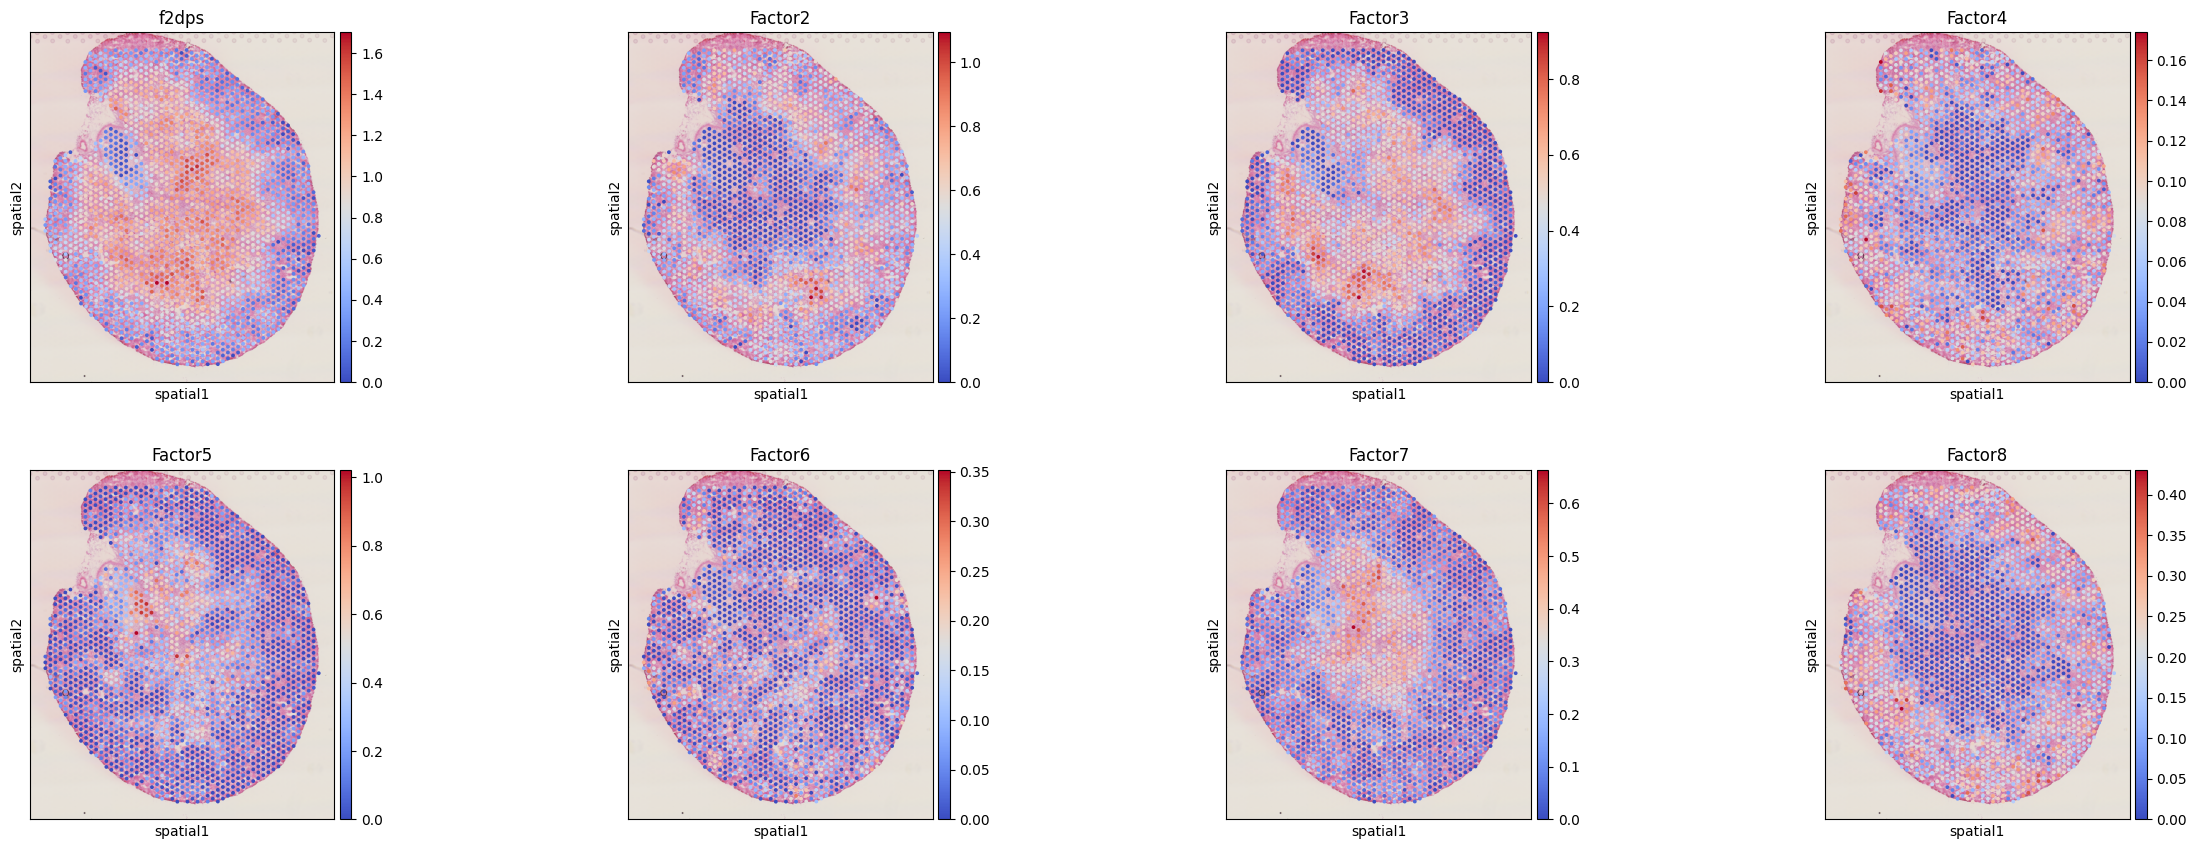

In [24]:
# transfer the NMF factors to the individual samples
for sample in lrdatas:
    # each
    lrdata = lrdatas[sample]
    
    # Get the NMF factors for the current sample from the full dataset
    temp = lrdata_all[lrdata_all.obs.index.isin(lrdata.obs.index), :]
    temp = temp[:, temp.var.index.isin(lrdata.var.index)]
    
    # extract from obsm
    ## TODO need to figure out how to handle .obsm & .uns - they keep getting copied over
    ad_nmf = li.fun.obsm_to_adata(temp, obsm_key='NMF_W', _uns=lrdata.uns)
    
    # plot
    sc.pl.spatial(ad_nmf, color=temp.obsm['NMF_W'].columns, cmap='coolwarm', title=sample)
    
    # save to MuData
    mdatas[sample].mod['nmf'] = ad_nmf

In [27]:
# overwrite the old mdatas
for sample in mdatas.keys():
    mdatas[sample].write(os.path.join(data_dir, "mdatas", sample + ".h5ad"))